# Cleaning Modes With Rational Filters

In [21]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [22]:
import matplotlib.pyplot as pl
import numpy as np
import qnm_filter
from gwpy.timeseries import TimeSeries
import copy

## Data

Download data

In [23]:
home_dir = "./MDC_waveforms/"

In [24]:
H_filename = "H-H1_NR_INJECTED-1126259448-16_TEOBResumS_GR_q_0.8_chi1_0.1_chi2_0.1_M72_dist452_incl1p59_ra1p68_decm1p27_psi3p93_flow7_nonoise_aligned.gwf"
L_filename = "L-L1_NR_INJECTED-1126259448-16_TEOBResumS_GR_q_0.8_chi1_0.1_chi2_0.1_M72_dist452_incl1p59_ra1p68_decm1p27_psi3p93_flow7_nonoise_aligned.gwf"

In [25]:
H_data = TimeSeries.read(home_dir + H_filename, 'H1:NR_INJECTED')
L_data = TimeSeries.read(home_dir + L_filename, 'L1:NR_INJECTED')

In [26]:
H_peak = np.argmax(H_data)

In [27]:
start_time = 1126259462.0031738 #H_data.times.value[H_peak] #1126259462.0031738 
t0 = H_data.times[H_peak]

In [87]:
import qnm
omega = qnm.modes_cache(s=-2, l=2, m=2, n=0)(a=0.71)[0]
mass = qnm_filter.Filter.mass_unit(68.5)

In [127]:
new_t = H_data.times.value[H_data.times.value>H_data.times.value[H_peak]]
ref_waveform = 2e-21*np.real(np.exp(-1j*omega/mass*(new_t - H_data.times.value[H_peak])+1j*np.pi*0.0))
tuned_waveform = 1.8*1e-21*np.real(np.exp(-1j*omega/mass*(new_t - H_data.times.value[H_peak])-1j*np.pi*0.4))

(1e-24, 1e-21)

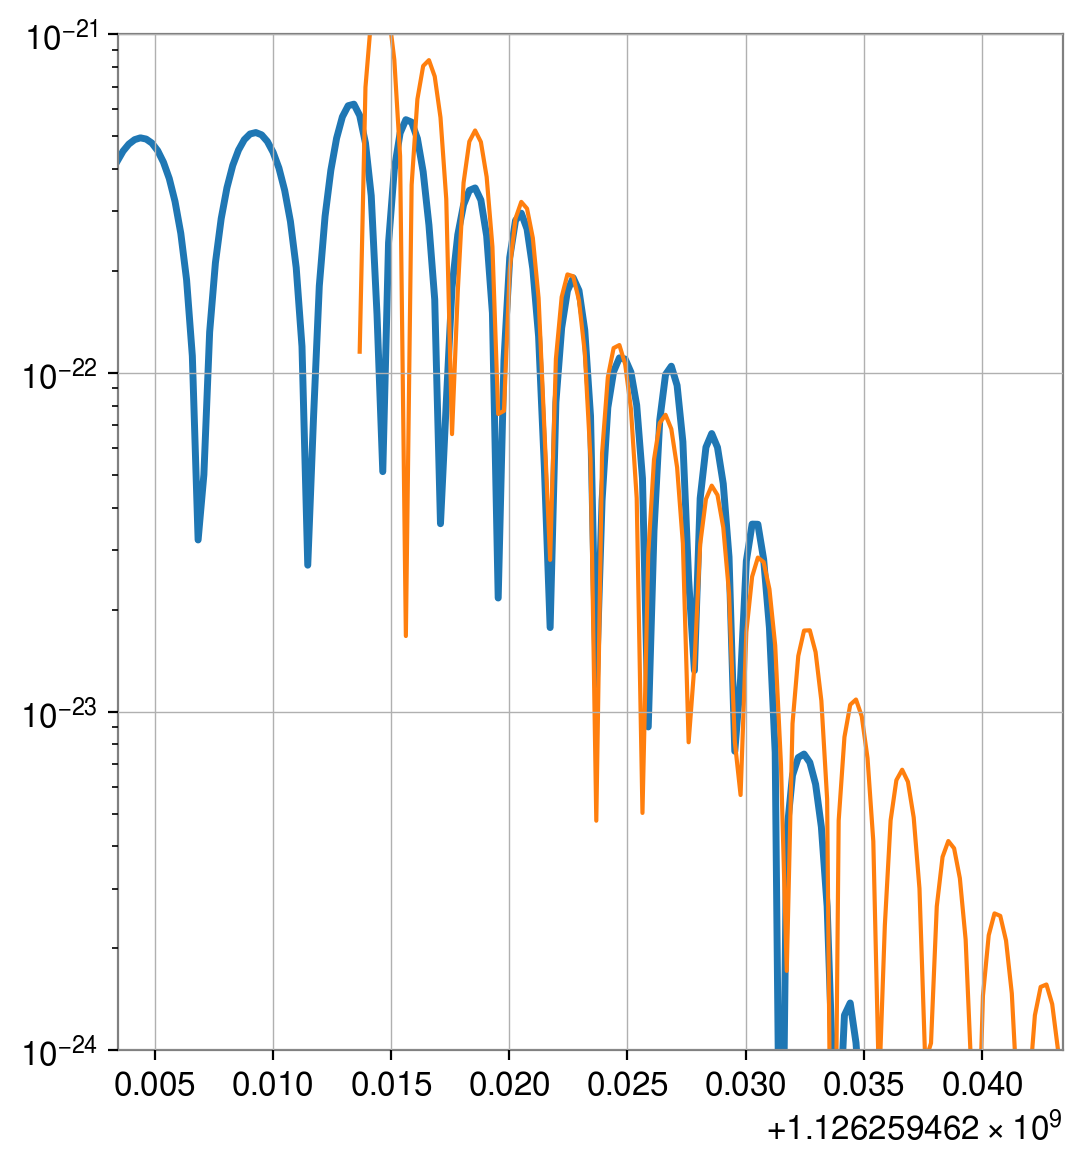

In [128]:
pl.semilogy(H_data.times, np.abs(H_data.value), lw = 2.5)
# pl.semilogy(new_t, np.abs(ref_waveform))
pl.semilogy(new_t, np.abs(tuned_waveform))
pl.xlim(H_data.times.value[H_peak]-0.01, H_data.times.value[H_peak]+0.03)
pl.ylim(1e-24, 1e-21)

In [141]:
fit = qnm_filter.Network()

In [142]:
fit.original_data = {}
fit.original_data['H1'] = qnm_filter.Data(H_data)

In [159]:
fit.add_filter(model_list = [(2,2,0)], mass = qnm_filter.Filter.mass_unit(68.5), chi = 0.71)

In [152]:
data = qnm_filter.Data(H_data)
data_in_freq = data.fft_data
freq = data.fft_freq
filter_in_freq = qnm_filter.Filter(model_list = [(2,2,0)], mass = 68.5, chi = 0.71).total_filter(freq)
ifft = np.fft.irfft(
    filter_in_freq * data_in_freq, norm="ortho", n=len(data)
)
fit.filtered_data['H1'] = qnm_filter.Data(ifft, index=data.index, ifo='H1')

(0.0, 0.5)

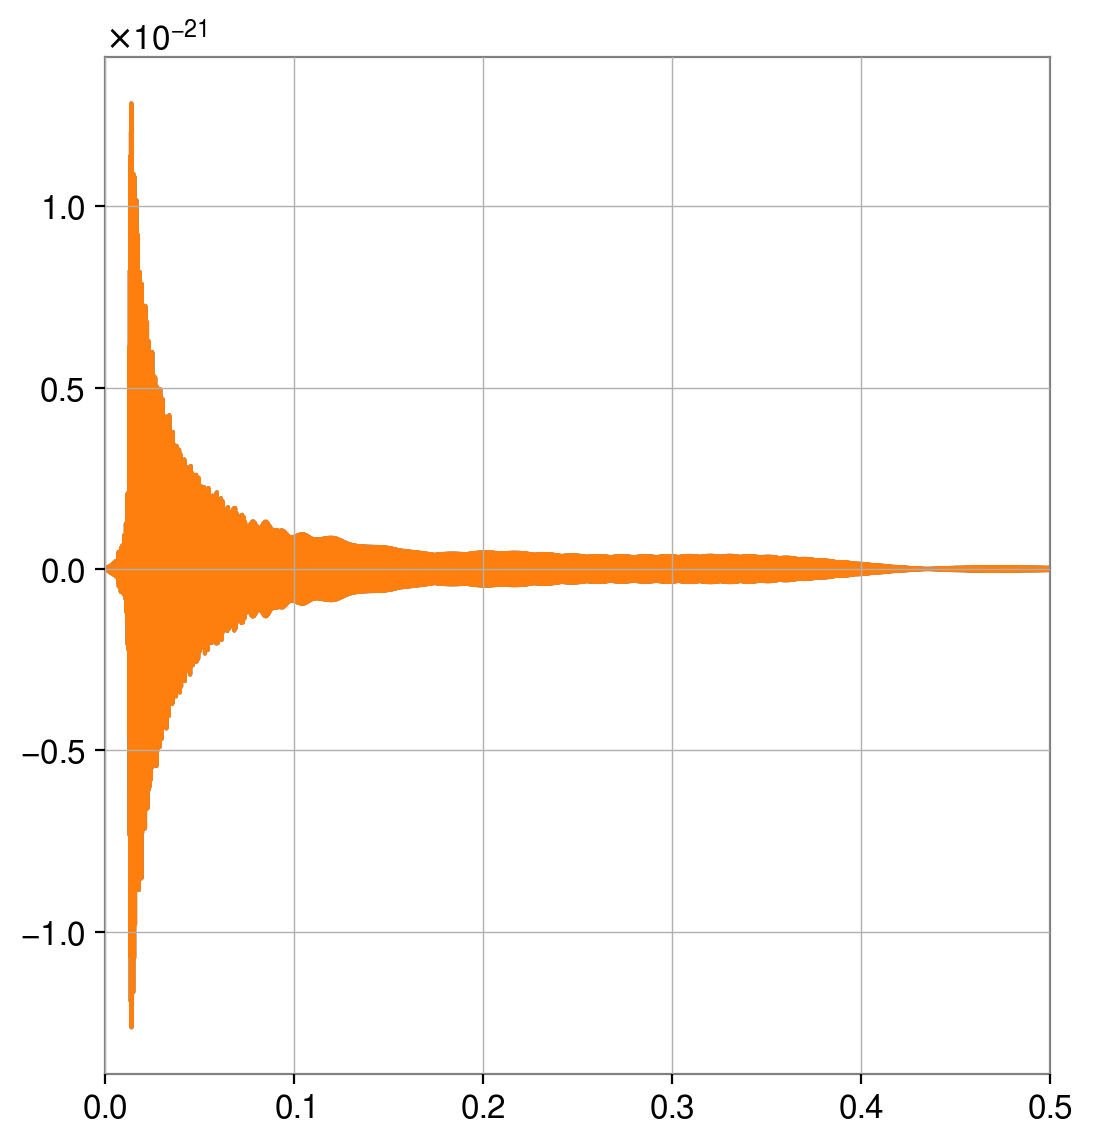

In [157]:
pl.plot(freq, np.real(data_in_freq))
pl.plot(freq, np.real(filter_in_freq*data_in_freq))
pl.xlim(0, 0.5)

(1e-24, 1e-21)

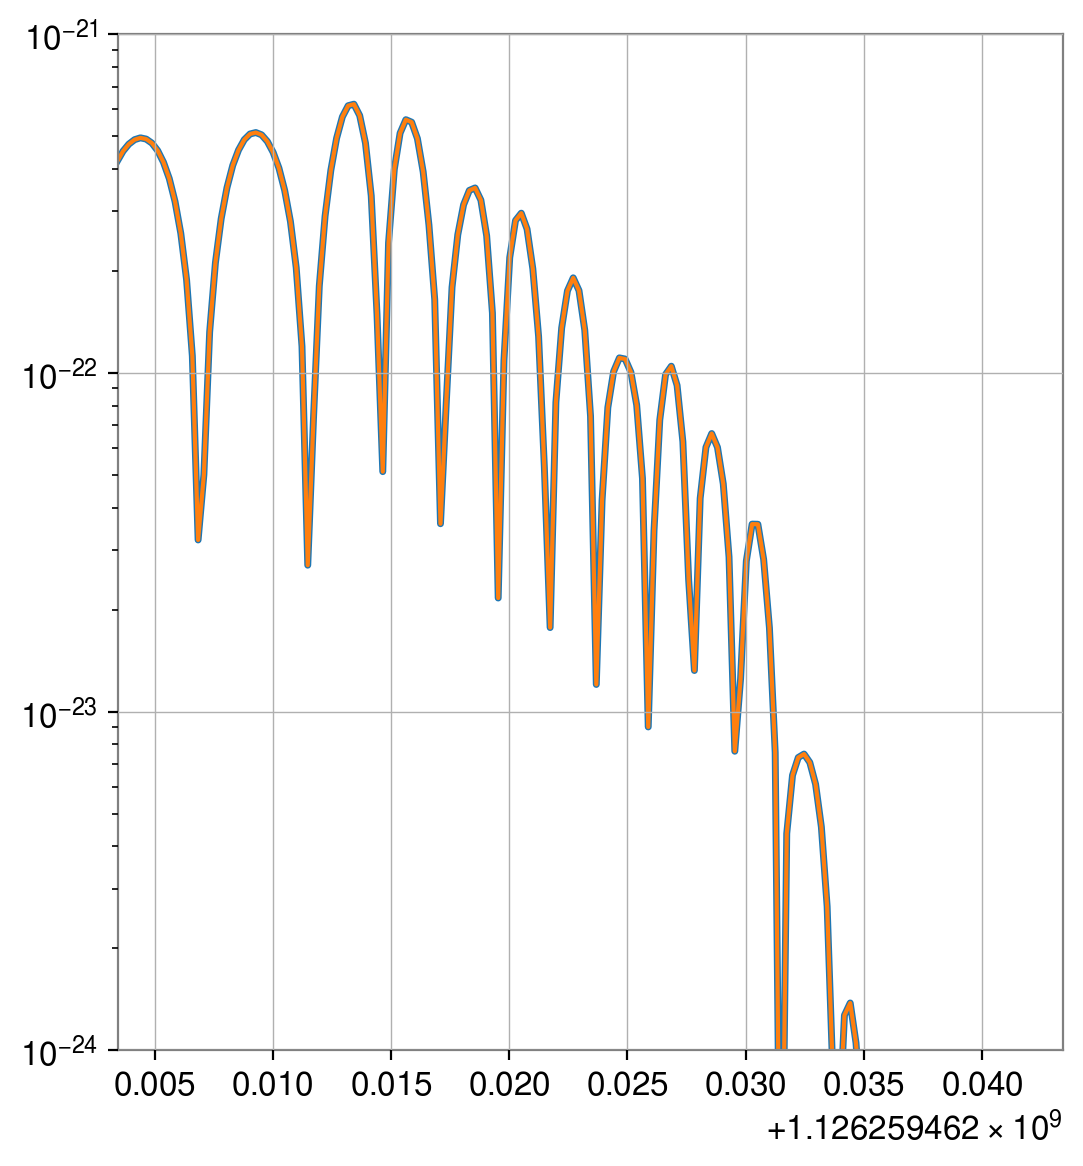

In [160]:
pl.semilogy(H_data.times, np.abs(H_data.value), lw = 2.5)
# pl.semilogy(new_t, np.abs(ref_waveform))
pl.semilogy(H_data.times, np.abs(fit.filtered_data['H1']))
pl.xlim(H_data.times.value[H_peak]-0.01, H_data.times.value[H_peak]+0.03)
pl.ylim(1e-24, 1e-21)

## Noise

In [29]:
length = len(H_data.times)
noise = np.random.normal(0,1e-22,length)

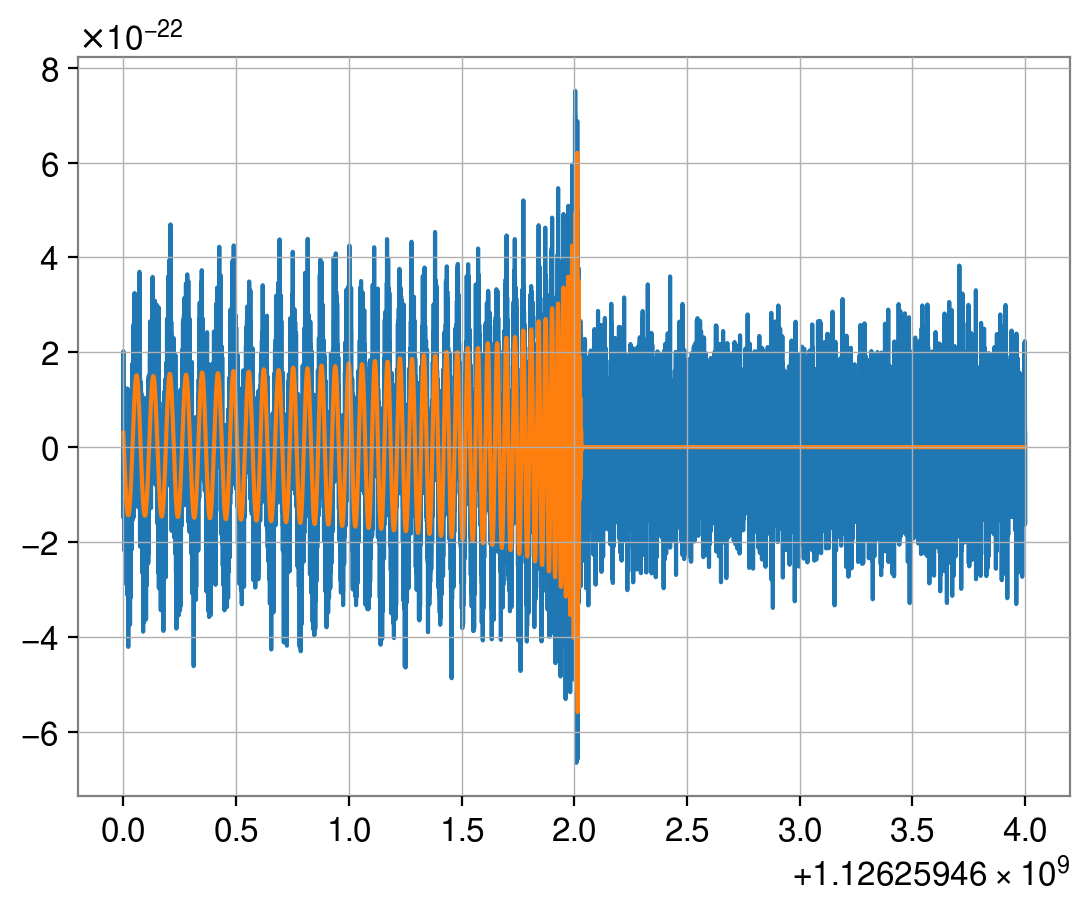

In [30]:
trim = int(3*len(H_data)/4)
pl.plot(H_data.times[trim:], H_data.value[trim:]+noise[trim:])
pl.plot(H_data.times[trim:], H_data.value[trim:])

In [31]:
H_waveform = qnm_filter.Data(H_data.value[trim:]+noise[trim:], index = H_data.times[trim:].value)
L_waveform = qnm_filter.Data(L_data.value[trim:]+noise[trim:], index = L_data.times[trim:].value)
noise_waveform = qnm_filter.Data(noise[trim:], index = L_data.times.value[trim:])

In [32]:
# np.savez("Systematics_MDC_Realisation0_H.npz", index = H_waveform.index, values = H_waveform.values)
# np.savez("Systematics_MDC_Realisation0_L.npz", index = L_waveform.index, values = L_waveform.values)

## Filter

In [33]:
input = dict(model_list = [(2, 2, 0)], #l, m, n
             # trucation time (geocenter, in second)
             t_init = 1126259462.4083147,
             # length of the analysis window (in second)
             window_width = 0.2,
             # sampling rate after conditioning (in Hz)
             srate = 2048,
             # sky localization
             ra = 1.95, dec = -1.27,
             # lower limit of the high-pass filter (in Hz)
             flow = 20)

fit = qnm_filter.Network(**input)

Load data

In [34]:
fit.original_data['H1'] = H_waveform
fit.original_data['L1'] = L_waveform
fit.detector_alignment()

In [35]:
fit.pure_noise = {}
fit.pure_noise['H1'] = noise_waveform
fit.pure_noise['L1'] = noise_waveform
fit.condition_data('original_data')
fit.condition_data('pure_noise')
fit.compute_acfs('pure_noise')
fit.cholesky_decomposition()
delta_mass = 1.0
delta_chi = 0.03
massspace = np.arange(34, 100, delta_mass)
chispace = np.arange(0.0, 0.95, delta_chi)
mass_grid, chi_grid = np.meshgrid(massspace, chispace)

## SNR

In [36]:
temp_H = fit.original_data['H1']
temp_idx = np.argmax(temp_H.values)
index_window = int(0.13*fit.sampling_n)
SNR_H = temp_H.values[temp_idx:temp_idx+index_window]
SNR_noise = fit.pure_noise['H1'].values[temp_idx:temp_idx+index_window]

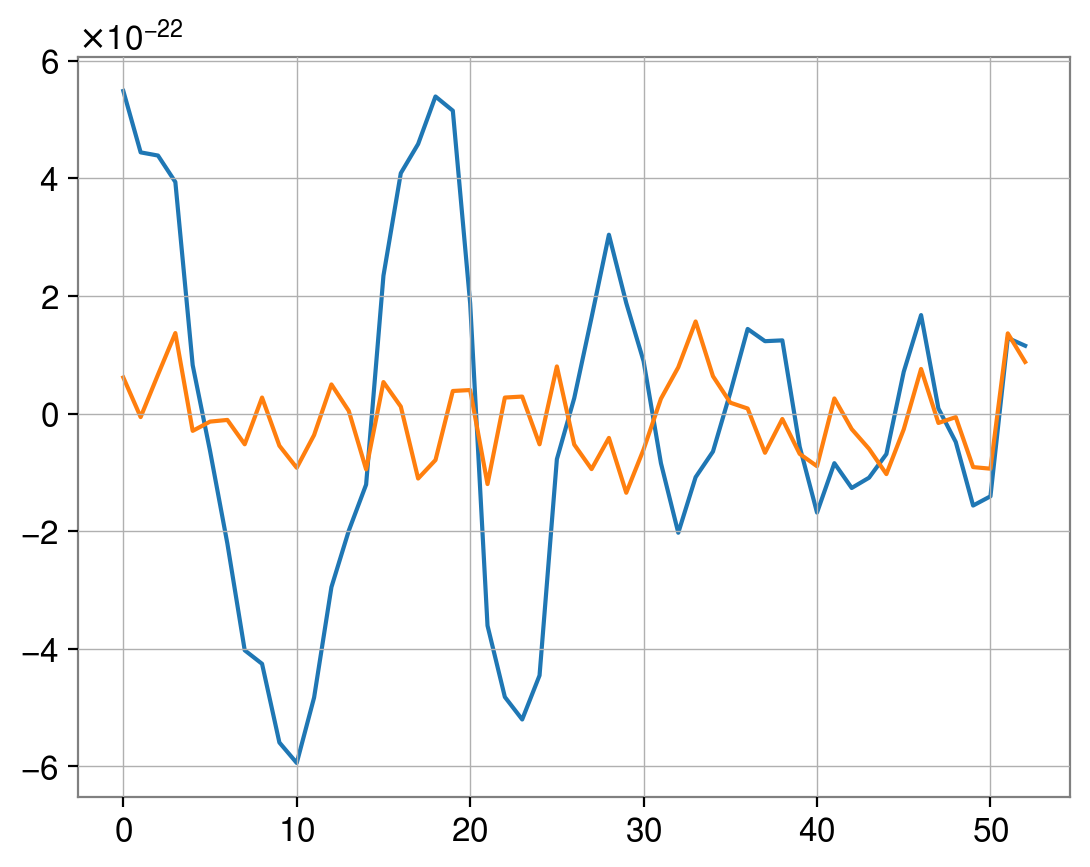

In [37]:
pl.plot(SNR_H)
pl.plot(SNR_noise)

In [38]:
SNR = np.sum(np.abs(SNR_H)**2) / np.sum(np.abs(SNR_noise)**2)
print("SNR = %.2f" % SNR)

SNR = 17.76


In [39]:
fit.first_index()
index_spacing = 5
num_iteration = 40
initial_offset = -200

fitnew=copy.deepcopy(fit)

In [40]:
t_array, saved_log_evidence = qnm_filter.evidence_parallel(fit, index_spacing, num_iteration, 
                                                           initial_offset, massspace, chispace, num_cpu = -1, 
                                                           verbosity=False, model_list = input['model_list'])

In [41]:
t_array_no_filter, saved_log_evidence_no_filter = qnm_filter.evidence_parallel(fitnew, index_spacing, num_iteration, 
                                                                               initial_offset, massspace, chispace, 
                                                                               num_cpu = -1, verbosity=False, 
                                                                               apply_filter=False, 
                                                                               model_list = input['model_list'])

In [42]:
saved_log_evidence /= np.log(10) # ln to lg
saved_log_evidence_no_filter /= np.log(10)

Text(0.5, 0, 't (ms)')

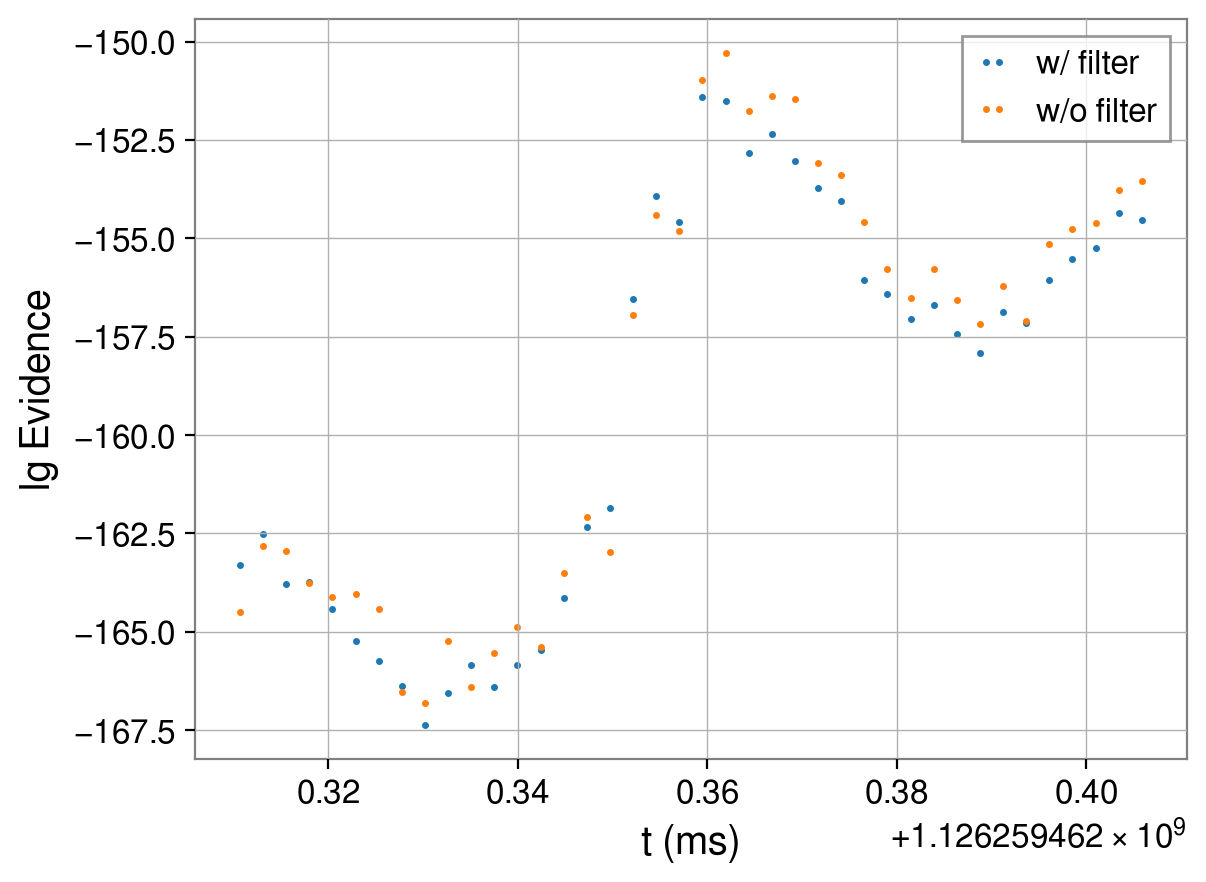

In [43]:
pl.plot(t_array, saved_log_evidence, 'o', ms=1.5, label='w/ filter')
pl.plot(t_array_no_filter, saved_log_evidence_no_filter, 'o', ms=1.5, label="w/o filter")
pl.legend()
pl.ylabel('lg Evidence')
pl.xlabel('t (ms)')

In [44]:
mid_index = int(2*len(t_array)/3)
linear, cov = np.polyfit(t_array[mid_index:], saved_log_evidence[mid_index:], 0, cov = True)

Text(0.5, 0, 't (ms)')

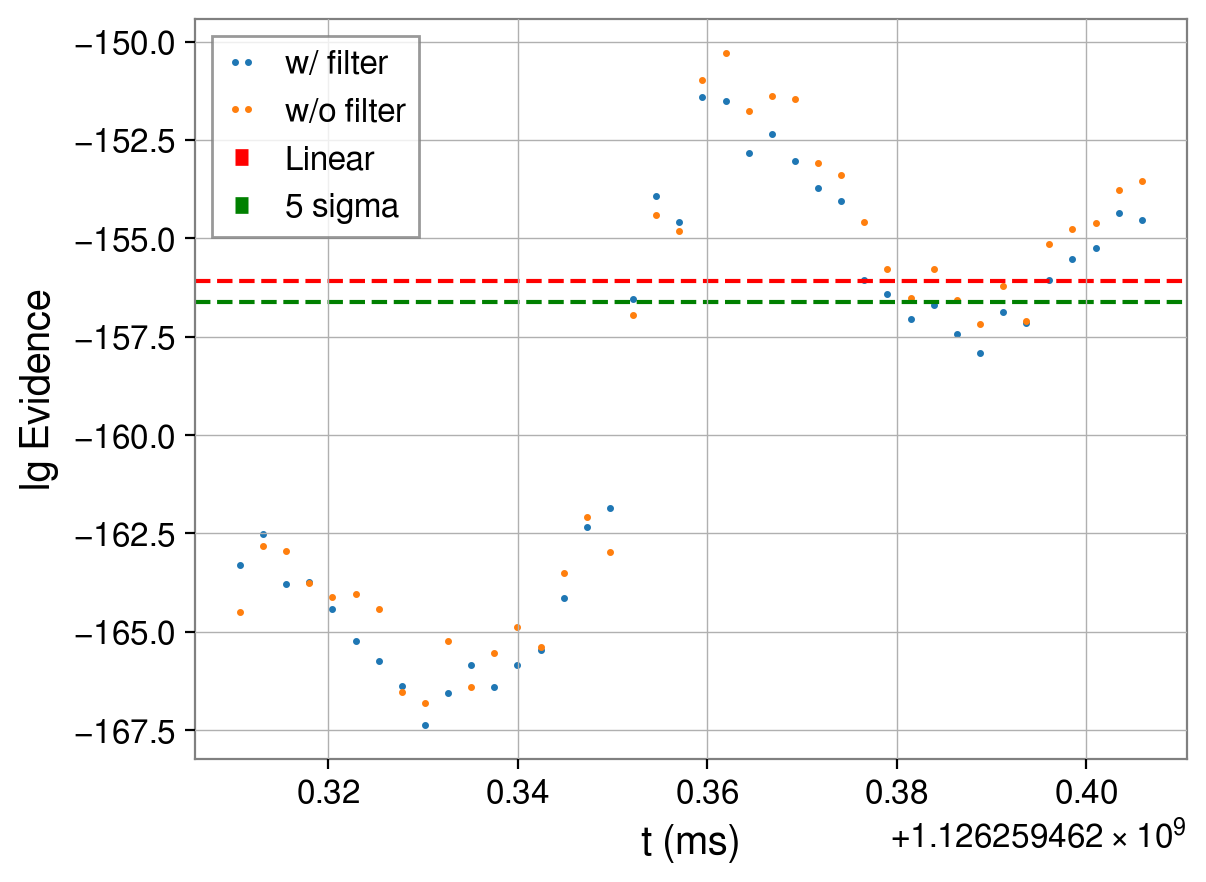

In [45]:
pl.plot(t_array, saved_log_evidence, 'o', ms=1.5, label='w/ filter')
pl.plot(t_array_no_filter, saved_log_evidence_no_filter, 'o', ms=1.5, label="w/o filter")
pl.axhline(linear[0], c = 'r', ls = '--', label = 'Linear')
pl.axhline(linear[0] - 5*cov[0], c = 'g', ls = '--', label = '5 sigma')
pl.legend()
pl.ylabel('lg Evidence')
pl.xlabel('t (ms)')

In [46]:
index = np.argmax(saved_log_evidence > linear[0] - 5*cov[0])
print("Start time determined by evidence curve: " + str(t_array[index]))
print("Difference to the IMR start time: " + str(t_array[index] - input['t_init']))

Start time determined by evidence curve: 1126259462.3521624
Difference to the IMR start time: -0.05615234375


In [64]:
input = dict(model_list = [(2, 2, 0)], #l, m, n
             # trucation time (geocenter, in second)
             t_init = 1126259461.9985352+3e-3,
             # length of the analysis window (in second)
             window_width = 0.2,
             # sampling rate after conditioning (in Hz)
             srate = 4096,
             # sky localization
             ra = 1.95, dec = -1.27,
             # lower limit of the high-pass filter (in Hz)
             flow = 20)

fit = qnm_filter.Network(**input)

In [65]:
fit.original_data['H1'] = H_waveform
fit.original_data['L1'] = L_waveform
fit.detector_alignment()

In [66]:
fit.pure_noise = {}
fit.pure_noise['H1'] = noise_waveform
fit.pure_noise['L1'] = noise_waveform
fit.condition_data('original_data')
fit.condition_data('pure_noise')
fit.compute_acfs('pure_noise')
fit.cholesky_decomposition()
delta_mass = 0.2
delta_chi = 0.005
massspace = np.arange(34, 100, delta_mass)
chispace = np.arange(0.0, 0.95, delta_chi)
mass_grid, chi_grid = np.meshgrid(massspace, chispace)

In [67]:
fit.first_index()
likelihood_data, _ = qnm_filter.parallel_compute(fit, massspace, chispace, num_cpu = 9, model_list = input['model_list'])
credible_region = qnm_filter.find_credible_region(likelihood_data)

Text(0, 0.5, '$\\chi_f$')

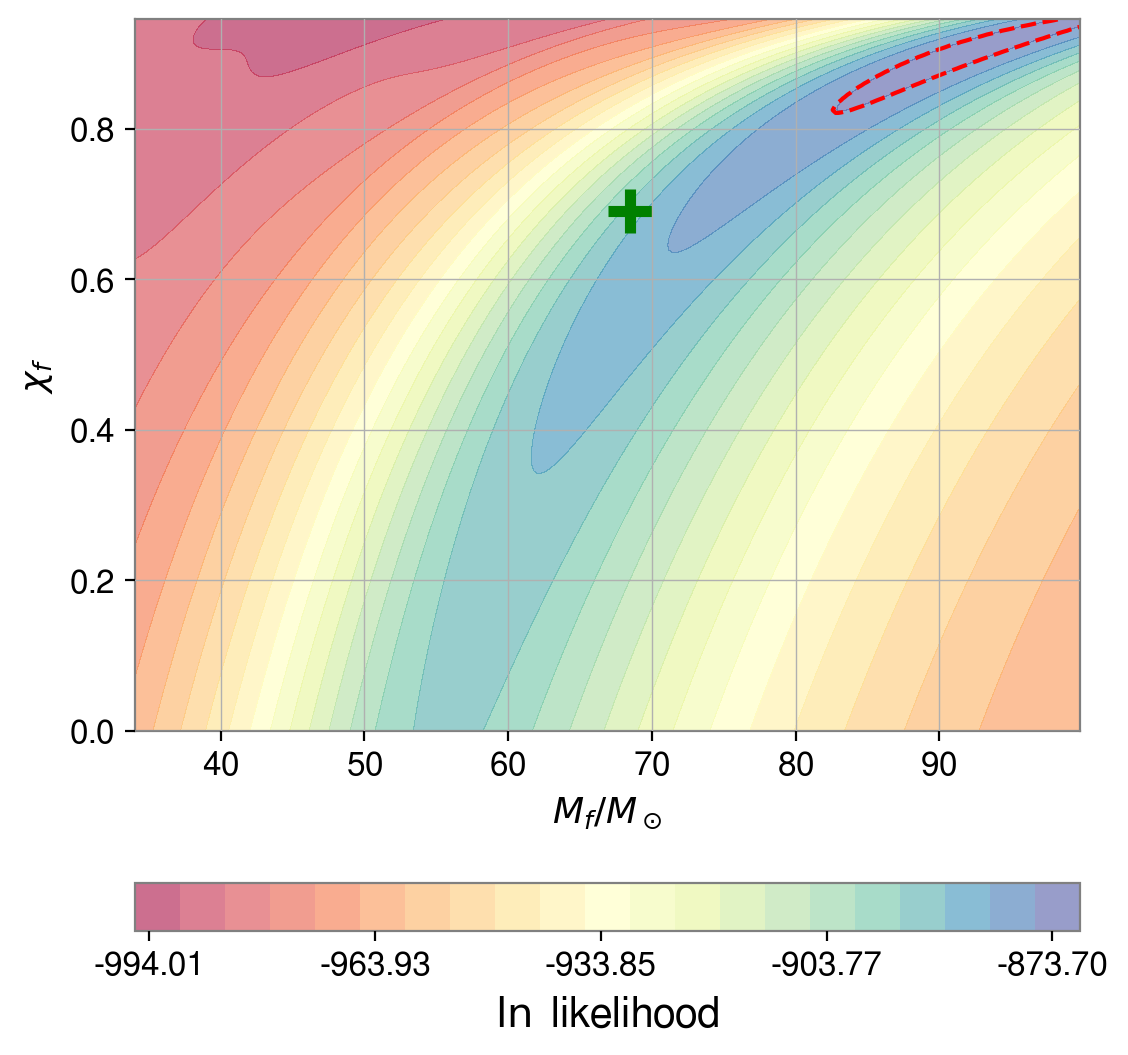

In [68]:
pl.rc('figure', figsize=(6.1, 6.6))
fig, ax = pl.subplots()
contours = ax.contourf(mass_grid, chi_grid, likelihood_data, 20, cmap='Spectral',
                       origin='lower', alpha=0.6, linestyles='--')
dotted = ax.contour(mass_grid, chi_grid, likelihood_data, [credible_region], colors = 'red', \
                   linestyles ='--')
ax.scatter(x=68.5, y=0.69, s=255, marker='+', 
           c='g', linewidths=4, label='IMR')


# coloarbar
cbar=fig.colorbar(contours, orientation="horizontal", 
                  pad=0.15, format='%3.2f')
cbar.set_label(r'$\ln$ likelihood', fontsize=15)
cbar.set_ticks(np.linspace(np.min(likelihood_data), np.max(likelihood_data), 5))

pl.xlabel(r'$M_f/M_\odot$', fontsize=13)
pl.ylabel(r'$\chi_f$', fontsize=13)

# ax.set_title(r'$\mathcal{F}_{220}+\mathcal{F}_{221}$')

Text(0, 0.5, '$\\chi_f$')

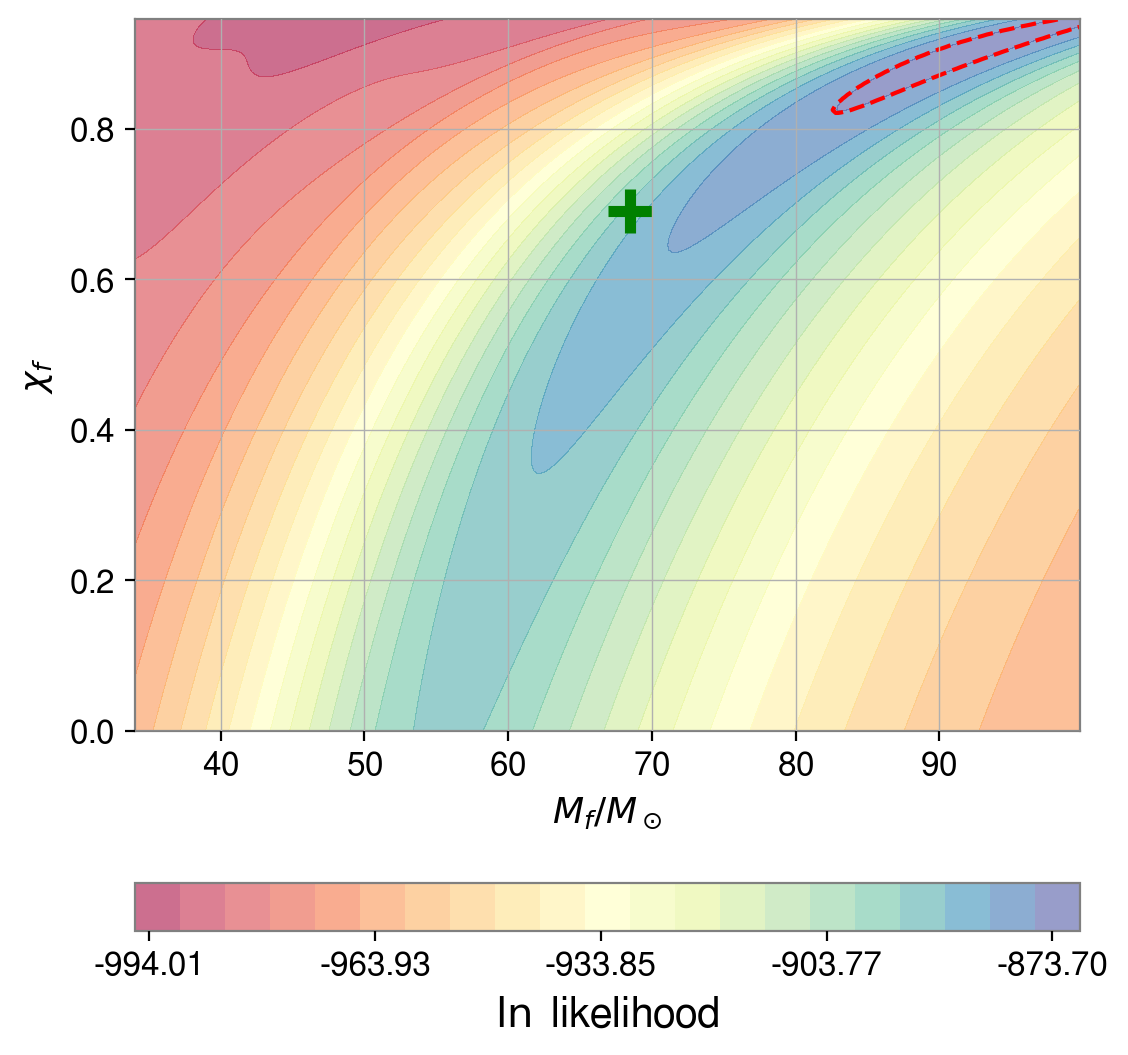

In [69]:
pl.rc('figure', figsize=(6.1, 6.6))
fig, ax = pl.subplots()
contours = ax.contourf(mass_grid, chi_grid, likelihood_data, 20, cmap='Spectral',
                       origin='lower', alpha=0.6, linestyles='--')
dotted = ax.contour(mass_grid, chi_grid, likelihood_data, [credible_region], colors = 'red', \
                   linestyles ='--')
ax.scatter(x=68.5, y=0.69, s=255, marker='+', 
           c='g', linewidths=4, label='IMR')


# coloarbar
cbar=fig.colorbar(contours, orientation="horizontal", 
                  pad=0.15, format='%3.2f')
cbar.set_label(r'$\ln$ likelihood', fontsize=15)
cbar.set_ticks(np.linspace(np.min(likelihood_data), np.max(likelihood_data), 5))

pl.xlabel(r'$M_f/M_\odot$', fontsize=13)
pl.ylabel(r'$\chi_f$', fontsize=13)

# ax.set_title(r'$\mathcal{F}_{220}+\mathcal{F}_{221}$')

In [53]:
3e-3/qnm_filter.Filter.mass_unit(68.5)

8.891625404149647